<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/06_pytorch_transfer_learning_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests

# import function for ploting the loss curves of trained models
try:
  from helper_functions import plot_loss_curves
except:
  with open('helper_functions.py', 'wb') as f:
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(response.content)
  from helper_functions import plot_loss_curves

### Get data 

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi directory exists.


### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3ebf0ab2e0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [7]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
[INFO] Total training time: 26.251 seconds


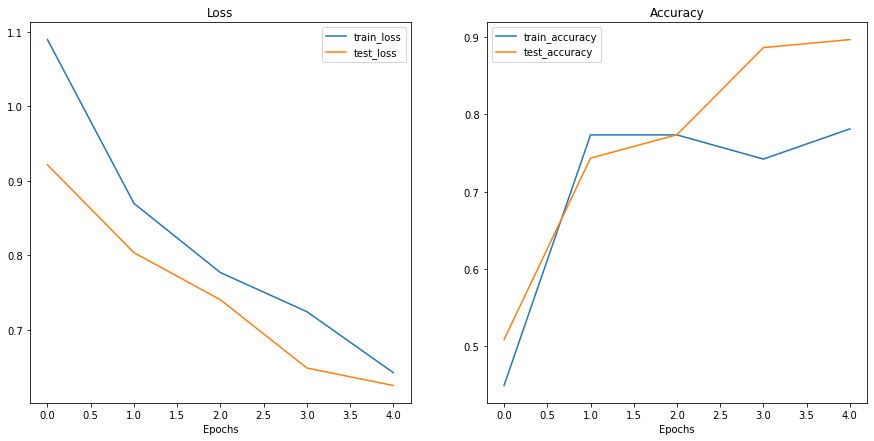

In [12]:
# compare the loss curves and accuracy between the training and test data
plot_loss_curves(model_0_results)

### Make predictions on the entire test dataset with the model

In [13]:
predictions = []
targets = []

# turn off training setting
model_0.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    # allocate to device
    X, y = X.to(device), y.to(device)
    # calculate logits
    y_logits = model_0(X)
    # calculate numerical class labels
    y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # store prediction and corresponding target label
    predictions.append(y_labels.cpu())
    targets.append(y.cpu())

# turn sequence of output tensors into single tensor
predictions_tensor = torch.cat(predictions)
targets_tensor = torch.cat(targets)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [14]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


In [15]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


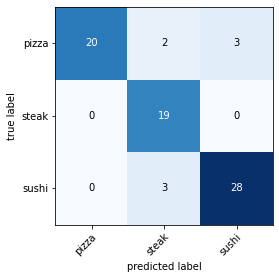

In [16]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# create confusion matrix on test data
confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(preds=predictions_tensor, target=targets_tensor)

fig, ax = plot_confusion_matrix(confusion_matrix_tensor.numpy(), class_names=class_names, figsize=(4,4))

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [17]:
from pathlib import Path

# store a list of all .jpg file paths
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
# create list of class labels for each corresponding test image path
test_image_label = [path.parent.stem for path in test_image_paths]

# store a list of dictionaries, each containing the results for each test image
predictions = []

for path in test_image_paths:
  pred_dict = {}
  # store the path and class label of the image within its dictionary
  pred_dict['image_path'] = path
  pred_dict['image_class'] = path.parent.stem

  from PIL import Image
  # transform each image and add a single batch dimension
  image = Image.open(path)
  image = simple_transform(image).unsqueeze(dim=0)
  # allocate to device
  image = image.to(device)

  model_0.eval()
  with torch.inference_mode():
    # predict logits
    logits = model_0(image)
    # predict probabilities with softmax
    probs = torch.softmax(logits, dim=1)
    # predict numerical class label
    label = torch.argmax(probs, dim=1)
    # store string class label
    str_label = class_names[label]

    # store the probability certainty and predicted class of the image
    pred_dict['pred_prob'] = probs.max().cpu().item()
    pred_dict['pred_class'] = str_label

    # store where prediction is correct or not
    pred_dict['correct'] = path.parent.stem == str_label

  predictions.append(pred_dict)

# show the first five image prediction dictionaries
predictions[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
  'image_class': 'steak',
  'pred_prob': 0.7832964062690735,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
  'image_class': 'steak',
  'pred_prob': 0.7461693286895752,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
  'image_class': 'steak',
  'pred_prob': 0.5315782427787781,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
  'image_class': 'steak',
  'pred_prob': 0.7808954119682312,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
  'image_class': 'steak',
  'pred_prob': 0.4080165922641754,
  'pred_class': 'steak',
  'correct': True}]

In [18]:
import pandas as pd

# create dataframe from list of dictionaries
prediction_df = pd.DataFrame(predictions)
prediction_df

,image_path,image_class,pred_prob,pred_class,correct
0,data/pizza_steak_sushi/test/steak/690177.jpg,steak,0.783296,steak,True
1,data/pizza_steak_sushi/test/steak/2144308.jpg,steak,0.746169,steak,True
2,data/pizza_steak_sushi/test/steak/354513.jpg,steak,0.531578,steak,True
3,data/pizza_steak_sushi/test/steak/1882831.jpg,steak,0.780895,steak,True
4,data/pizza_steak_sushi/test/steak/3873283.jpg,steak,0.408017,steak,True
...,...,...,...,...,...
70,data/pizza_steak_sushi/test/sushi/1987407.jpg,sushi,0.478293,sushi,True
71,data/pizza_steak_sushi/test/sushi/2540511.jpg,sushi,0.565844,sushi,True
72,data/pizza_steak_sushi/test/sushi/2276986.jpg,sushi,0.399065,steak,False
73,data/pizza_steak_sushi/test/sushi/3196729.jpg,sushi,0.486851,sushi,True


In [19]:
# filter and sort for the top 5 worst predictions
five_worst_predictions = prediction_df.sort_values(['correct', 'pred_prob'], ascending=[True, False])[0:5]
five_worst_predictions

,image_path,image_class,pred_prob,pred_class,correct
66,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.547931,steak,False
32,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454041,sushi,False
63,data/pizza_steak_sushi/test/sushi/1172255.jpg,sushi,0.448240,steak,False
20,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.428751,sushi,False
24,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,0.424841,steak,False


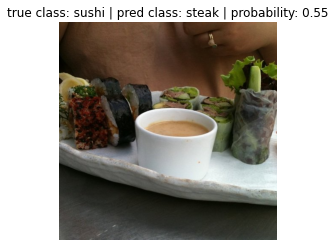

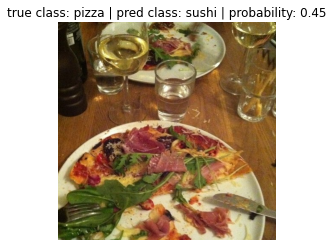

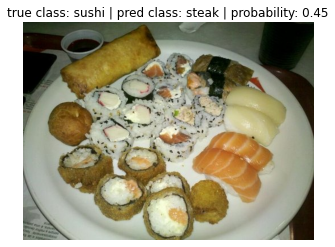

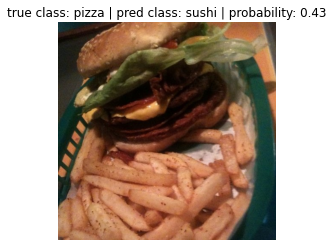

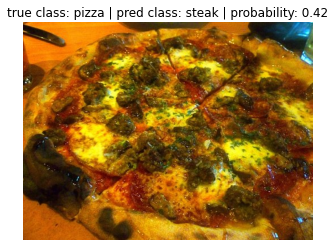

In [20]:
# iterate through each row in the dataframe
for row in five_worst_predictions.iterrows():
  # create tensor from image path stored in dataframe
  # row[1] contains a series of columns and their values
  image = torchvision.io.read_image(str(row[1][0]))

  # display image and prediction results
  plt.figure()
  plt.imshow(image.permute(1, 2, 0))
  plt.title(f"true class: {row[1][1]} | pred class: {row[1][3]} | probability: {row[1][2]:.2f}")
  plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [21]:
import requests
from PIL import Image

# download custom image of a steak
custom_steak_path = data_path / "custom_steak.jpeg"
if not custom_steak_path.is_file():
  with open(custom_steak_path, "wb") as f:
    response = requests.get("https://images.unsplash.com/photo-1600891964092-4316c288032e?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8M3x8c3RlYWt8ZW58MHx8MHx8&auto=format&fit=crop&w=500&q=60")
    f.write(response.content)
else:
  print(f"{custom_steak_path} already exists")

# store image using Python Image Library
custom_steak_image = Image.open(custom_steak_path)
# apply the same transforms used to train the model and add single batch dimension
custom_steak_tensor = simple_transform(custom_steak_image).unsqueeze(dim=0)
# allocate to device
custom_steak_tensor = custom_steak_tensor.to(device)

# predict the class label for custom steak image
model_0.eval()
with torch.inference_mode():
  steak_logit = model_0(custom_steak_tensor)
  steak_label = torch.argmax(torch.softmax(steak_logit, dim=1), dim=1)

print(f"True class: steak")
print(f"Predicted class: {class_names[steak_label]}")


data/custom_steak.jpeg already exists
True class: steak
Predicted class: steak


In [22]:
import requests
from PIL import Image

# download custom image of a pizza
custom_pizza_path = data_path / "custom_pizza.jpeg"
if not custom_pizza_path.is_file():
  with open(custom_pizza_path, "wb") as f:
    response = requests.get("https://media.istockphoto.com/id/888274908/photo/pizza-with-ingredients.jpg?s=612x612&w=0&k=20&c=TbOExzC7cnG70pkV2YUGF45woNKTG_vyGDC8IEaQAb0=")
    f.write(response.content)
else:
  print(f"{custom_pizza_path} already exists")

# create tensor image from steak image path
custom_pizza_image = Image.open(custom_pizza_path)
# apply the same transform used for training and add single batch dimension
custom_pizza_tensor = simple_transform(custom_pizza_image).unsqueeze(dim=0)
# allocate to device
custom_pizza_tensor = custom_pizza_tensor.to(device)

# predict the class label for custom pizza image
model_0.eval()
with torch.inference_mode():
  pizza_logit = model_0(custom_pizza_tensor)
  pizza_label = torch.argmax(torch.softmax(pizza_logit, dim=1), dim=1)

print(f"True class: pizza")
print(f"Predicted class: {class_names[pizza_label]}")

data/custom_pizza.jpeg already exists
True class: pizza
Predicted class: pizza


## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [23]:
# import torchinfo or install if required
try:
  from torchinfo import summary
except:
  # install torchinfo
  !pip install torchinfo
  from torchinfo import summary

In [24]:
# store the best available weights from the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# create new model initialized with these weights
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# freeze all weights in the features component of the model
for param in model_1.features.parameters():
  param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# modify the output layer of the model to accomodate the number of classes in the data
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

# display a summary of the model architecture
summary(model_1, input_size=(32, 3, 224, 244), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 244]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 244]         [32, 1280, 7, 8]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 244]         [32, 32, 112, 122]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 244]         [32, 32, 112, 122]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 122]        [32, 32, 112, 122]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 122]        [32, 32, 112, 122]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 122]        [32, 16, 112, 122]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 122]        [32

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [26]:
# train the new model for 10 epochs
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0225 | train_acc: 0.5430 | test_loss: 0.9111 | test_acc: 0.5814
Epoch: 2 | train_loss: 0.8502 | train_acc: 0.6836 | test_loss: 0.8354 | test_acc: 0.5701
Epoch: 3 | train_loss: 0.7397 | train_acc: 0.7422 | test_loss: 0.7622 | test_acc: 0.6619
Epoch: 4 | train_loss: 0.6568 | train_acc: 0.8047 | test_loss: 0.6409 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.5890 | train_acc: 0.8945 | test_loss: 0.5888 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.6127 | train_acc: 0.7656 | test_loss: 0.5632 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5747 | train_acc: 0.7852 | test_loss: 0.5282 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5278 | train_acc: 0.7891 | test_loss: 0.4743 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5221 | train_acc: 0.8008 | test_loss: 0.4742 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4896 | train_acc: 0.8086 | test_loss: 0.5126 | test_acc: 0.8665


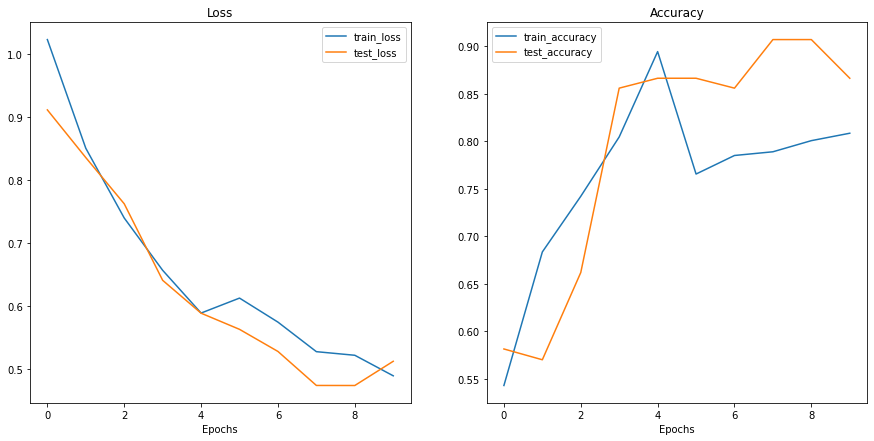

In [27]:
# compare the loss curves and accuracy between the training and test data
plot_loss_curves(model_1_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [28]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data/pizza_steak_sushi_20_percent directory exists.


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [29]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [30]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f3e02fdb550>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [31]:
# store the best available weights of the pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# initialize new model using these weights
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# turn off training and tracking gradients for weights within the features component of the model
for param in model_2.features.parameters():
  param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# modify the classifier component to accomodate the number of classes for the problem
model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

# display a summary of the model architecture
summary(model_2, input_size=(32, 3, 224, 244), col_names=['input_size', 'output_size', 'trainable'])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 244]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 244]         [32, 1280, 7, 8]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 244]         [32, 32, 112, 122]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 244]         [32, 32, 112, 122]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 122]        [32, 32, 112, 122]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 122]        [32, 32, 112, 122]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 122]        [32, 16, 112, 122]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 122]        [32

In [32]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

### Train a model with 20% of the data

In [33]:
# train the new model for 10 epochs using 20% extra data
model_2_results = engine.train(model=model_2,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0225 | train_acc: 0.5430 | test_loss: 0.9111 | test_acc: 0.5814
Epoch: 2 | train_loss: 0.8502 | train_acc: 0.6836 | test_loss: 0.8354 | test_acc: 0.5701
Epoch: 3 | train_loss: 0.7397 | train_acc: 0.7422 | test_loss: 0.7622 | test_acc: 0.6619
Epoch: 4 | train_loss: 0.6568 | train_acc: 0.8047 | test_loss: 0.6409 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.5890 | train_acc: 0.8945 | test_loss: 0.5888 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.6127 | train_acc: 0.7656 | test_loss: 0.5632 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5747 | train_acc: 0.7852 | test_loss: 0.5282 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5278 | train_acc: 0.7891 | test_loss: 0.4743 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5221 | train_acc: 0.8008 | test_loss: 0.4742 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4896 | train_acc: 0.8086 | test_loss: 0.5126 | test_acc: 0.8665


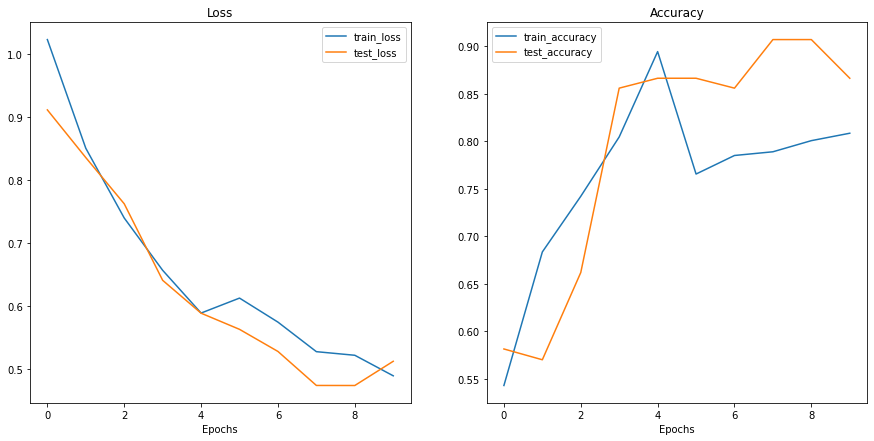

In [34]:
# compare the loss curves and accuracy between the training and test data
plot_loss_curves(model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [35]:
# store best available weights from pretrained EfficientNetB2 model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# store the transform used to preprocess the data used to train the pretrained model
transform = weights.transforms()

# create data loaders and apply transform to data batches
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                              test_dir=test_dir_20_percent,
                                                                              transform=transform,
                                                                              batch_size=32)

# initialize new pretrained model
model_3 = torchvision.models.efficientnet_b2(weights=weights).to(device)

# display architecture of the pretrained model BEFORE modifications to architecture
summary(model_3, input_size=(32, 3, 288, 288), col_names=['input_size', 'output_size', 'trainable'])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 1000]                True
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        True
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        True
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        True
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32, 16, 14

In [36]:
# freeze feature component training parameters
for param in model_3.features.parameters():
  param.requires_grad = False

# modify classifier component to accomodate the number of classes used in the problem
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

# display the architecture of the modified pretrained model
# only weights in the classfier are now trainable and the model output size has been reduced from 1000 to 3
summary(model_3, input_size=(32, 3, 288, 288), col_names=['input_size', 'output_size', 'trainable'])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        False
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32

In [37]:
# loss function
loss_fn = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train model
model_3_results = engine.train(model=model_3,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9623 | train_acc: 0.5500 | test_loss: 0.7209 | test_acc: 0.9415
Epoch: 2 | train_loss: 0.6879 | train_acc: 0.8625 | test_loss: 0.5721 | test_acc: 0.9443
Epoch: 3 | train_loss: 0.5654 | train_acc: 0.8917 | test_loss: 0.4759 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.4391 | train_acc: 0.9021 | test_loss: 0.4216 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.4111 | train_acc: 0.9146 | test_loss: 0.3818 | test_acc: 0.9534
Epoch: 6 | train_loss: 0.4209 | train_acc: 0.8938 | test_loss: 0.3392 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4157 | train_acc: 0.8396 | test_loss: 0.3171 | test_acc: 0.9597
Epoch: 8 | train_loss: 0.3931 | train_acc: 0.9083 | test_loss: 0.3392 | test_acc: 0.9261
Epoch: 9 | train_loss: 0.3649 | train_acc: 0.8917 | test_loss: 0.3050 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3545 | train_acc: 0.8604 | test_loss: 0.2723 | test_acc: 0.9688


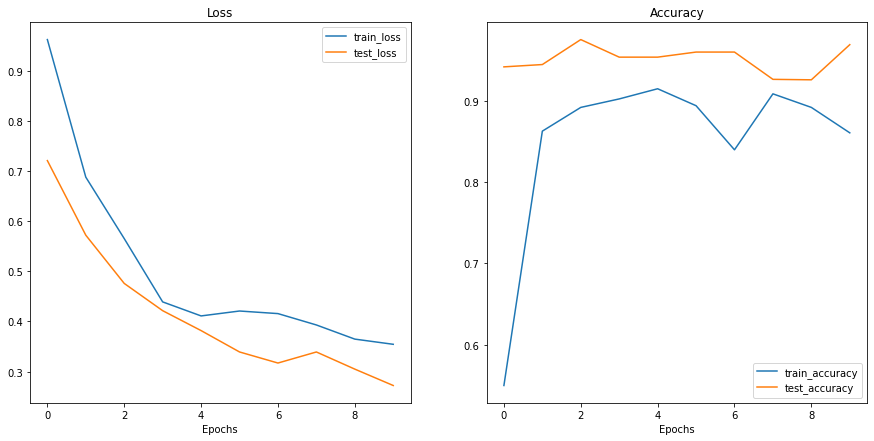

In [39]:
# compare the loss curves and accuracy between the training and test data
plot_loss_curves(model_3_results)

In [40]:
# check the accuracy of predictions over the entire test data
pred_y = []
true_y = []

model_3.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    # allocate data to device
    X, y = X.to(device), y.to(device)

    logit = model_3(X)
    label = torch.argmax(torch.softmax(logit, dim=1), dim=1)
    # store prediction and real target
    pred_y.append(label.cpu())
    true_y.append(y.cpu())

# create a tensor of all data from list of batches
pred_y_tensor = torch.cat(pred_y)
true_y_tensor = torch.cat(true_y)

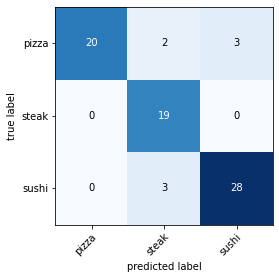

In [41]:
# plot a confusion matrix to show model accuracy
confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_marix_tensor = confusion_matrix(preds=pred_y_tensor, target=true_y_tensor)

fig, ax = plot_confusion_matrix(confusion_matrix_tensor.numpy(), class_names=class_names, figsize=(4, 4))